# This notebook produces cluster star results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
from chronology import setup, run_mcmc, make_plots
from isochrones import StarModel
import pandas as pd
import emcee

from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

To do: 

git rid of the gyro_only option

Convert the dictionary into the param_dict thing

So the user just has to provide the observables and, if they want, alll the other choices are made for them. 
They get posterior samples back.

Load the Praesepe data.

In [2]:
df = pd.read_csv("../data/praesepe_no_outliers.csv")
df.head()

,Unnamed: 0,praesepe_oid,col1,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,...,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE,period
0,1,2,1,1635721458409799680,Gaia DR2 664963024499946496,958732839,2015.5,130.843872,0.039013,21.671633,...,2,10.34,1,1,All,2M,Simbad,130.844045,21.671699,11.17
1,8,9,8,1635721458409799680,Gaia DR2 665004702861616256,808383652,2015.5,131.366265,0.056806,21.653530,...,K,10.34,1,1,All,2M,Simbad,131.366439,21.653576,4.92
2,11,12,11,1635721458409799680,Gaia DR2 665129291274350976,1023339599,2015.5,130.150810,0.044626,21.561657,...,D,11.45,2,2,All,2M,Simbad,130.150986,21.561719,9.02
3,16,17,16,1635721458409799680,Gaia DR2 664337230586013312,672933698,2015.5,129.601086,0.055733,20.106007,...,K,10.41,0,1,All,2M,Simbad,129.601250,20.106063,4.26
4,18,19,18,1635721458409799680,Gaia DR2 664455118847781760,1237355236,2015.5,130.093225,0.029071,20.640806,...,D,14.17,2,2,All,2M,Simbad,130.093397,20.640869,14.73


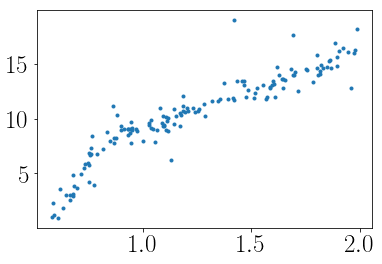

In [3]:
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.Prot1, ".")

The setup

In [4]:
# obs0 = pd.DataFrame(dict({"G": df.phot_g_mean_mag, "G_err": df.phot_g_mean_mag*.01,
#                           "bp": df.phot_bp_mean_mag, "bp_err": df.phot_bp_mean_mag*.01,
#                           "rp": df.phot_rp_mean_mag, "rp_err": df.phot_rp_mean_mag*.01,
#                           "Kepler": df.Kpmag, "Kepler_err": df.Kpmag*.01,
#                           "parallax": df.parallax, "parallax_err": df.parallax_error, 
#                           "prot": df.Prot1, "prot_err": df.Prot1*.1,
#                           "BV": df.phot_bp_mean_mag - df.phot_rp_mean_mag,
#                           "BV_err": (df.phot_bp_mean_mag - df.phot_rp_mean_mag)*.1}))
# obs = obs0.iloc[0]

In [5]:
obs = pd.DataFrame(dict({"G": df.phot_g_mean_mag, "G_err": df.phot_g_mean_mag*.01,
                         "bp": df.phot_bp_mean_mag, "bp_err": df.phot_bp_mean_mag*.01,
                         "rp": df.phot_rp_mean_mag, "rp_err": df.phot_rp_mean_mag*.01,
                         "Kepler": df.Kpmag, "Kepler_err": df.Kpmag*.01,
                         "parallax": df.parallax, "parallax_err": df.parallax_error}))
prot, prot_err = df.Prot1, df.Prot1*.1

# # Set up the StarModel object needed to calculate the likelihood.
# iso_params = {"G": (obs.G, obs.G_err),
#               "bp": (obs.bp, obs.bp_err),
#               "rp": (obs.rp, obs.rp_err),
#               "Kepler": (obs.Kepler, obs.Kepler_err),
#               "parallax": (obs.parallax, obs.parallax_err)}  # Isochrones.py takes milliarcseconds
# print(type(iso_params))
# print(type(iso_params.iloc[0].to_dict()))    
# print(iso_params.iloc[0].to_dict())

Run MCMC

In [6]:
# def star_fit(param_dict, prot, prot_err, inits=[1., 9., 0., .5, .01], nwalkers=24, max_n=100000, 
#              gyro_only=False, iso_only=False, savedir="."):
    
#     assert gyro_only + iso_only < 2, "Either gyro_only or iso_only can be true, not both"

#     # Set the initial values
#     mass_init, age_init, feh_init, distance_init, Av_init = inits
#     eep_init = mist.eep_from_mass(mass_init, age_init, feh_init)
    
#     # sample in linear eep, log10(age), linear feh, ln(distance) and linear Av.
#     p_init = np.array([eep_init, age_init, feh_init, np.log(distance_init), Av_init])
    
#     np.random.seed(42)
    
#     # Set up the backend
#     # Don't forget to clear it in case the file already exists
#     filename = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
#     backend = emcee.backends.HDFBackend(filename)
#     nwalkers, ndim = 24, 5
#     backend.reset(nwalkers, ndim)
    
#     # Set up the StarModel object needed to calculate the likelihood.
#     mod = StarModel(mist, **param_dict)  # Set up the StarModel isochrones object.
#     args = [mod, prot, prot_err, iso_only]  # the lnprob arguments
        
#     # Run the MCMC
#     sampler = run_mcmc(obs, args, p_init, backend, ndim=ndim, nwalkers=nwalkers, max_n=max_n)
    
#     # Save the samples
#     samples = sampler.flatchain
#     print("Saving samples...")
#     with h5py.File("{0}/{1}.h5".format(savedir, str(i).zfill(4)), "w") as f:
#         data = f.create_dataset("samples", np.shape(samples))
#         data[:, :] = samples
#     return sampler

In [7]:
# savedir = "cluster_results/iso_and_gyro"
# iso_only = False

# N = len(df)
# for i in range(0, N):
#     print(i, "of", N)
        
#     iso_params = {"G": (obs.G[i], obs.G_err[i]),
#                   "bp": (obs.bp[i], obs.bp_err[i]),
#                   "rp": (obs.rp[i], obs.rp_err[i]),
#                   "Kepler": (obs.Kepler[i], obs.Kepler_err[i]),
#                   "parallax": (obs.parallax[i], obs.parallax_err[i])} 
    
#     sampler = star_fit(iso_params, prot[i], prot_err[i], savedir=savedir)
    
#     truths = [None, np.log10(650e6), None, None, None]
#     print("truths = ", truths)
#     make_plots(sampler, i, truths, savedir)
            
#     # Make the plots
#     samples = sampler.flatchain
#     mass_samps = mist.mass(samples[:, 0], samples[:, 1], samples[:, 2])
#     plt.hist(mass_samps, 50);
#     plt.savefig("{0}/{1}_marginal_mass".format(savedir, str(i).zfill(4)))
#     plt.close()

In [8]:
class star(object):

    def __init__(self, iso_params, prot, prot_err):
        """
        params
        -------
        iso_params: dictionary
            A dictionary containing all available photometric and spectroscopic parameters for a star,
            as well as its parallax.
            All parameters should also have associated uncertainties.
            This dictionary should be similar to the standard one created for isochrones.py.
        prot: float
            The rotation period of the star in days.
        prot_err: float
            The uncertainty on the stellar rotation period in days.
        """
        
        self.iso_params = iso_params
        self.prot = prot
        self.prot_err = prot_err
        
    def fit(self, inits=[1., 9., 0., .5, .01], nwalkers=24, max_n=100000,
            iso_only=False, savedir="."):
        """
        params
        ------
        inits: list
            A list of default initial values to use for mass, age, feh, distance and Av,
            if alternatives are not provided.
        nwalkers: int
            The number of walkers to use with emcee.
        max_n: int
            The maximum number of samples to obtain.
        iso_only: boolean
            If true only the isochronal likelihood function will be used.
        savedir: str
            The name of the directory where the 
        """
        assert gyro_only + iso_only < 2, "Either gyro_only or iso_only can be true, not both"
    
        # Set the initial values
        mass_init, age_init, feh_init, distance_init, Av_init = inits
        eep_init = mist.eep_from_mass(mass_init, age_init, feh_init)
    
        # sample in linear eep, log10(age), linear feh, ln(distance) and linear Av.
        p_init = np.array([eep_init, age_init, feh_init, np.log(distance_init), Av_init])
    
        np.random.seed(42)
    
        # Set up the backend
        # Don't forget to clear it in case the file already exists
        filename = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
        backend = emcee.backends.HDFBackend(filename)
        nwalkers, ndim = 24, 5
        backend.reset(nwalkers, ndim)
    
        # Set up the StarModel object needed to calculate the likelihood.
        mod = StarModel(mist, **self.iso_params)  # Set up the StarModel isochrones object.
        args = [mod, self.prot, self.prot_err, iso_only]  # the lnprob arguments
    
        # Run the MCMC
        sampler = run_mcmc(obs, args, p_init, backend, ndim=ndim, nwalkers=nwalkers, max_n=max_n)
    
        # Save the samples
        samples = sampler.flatchain
        print("Saving samples...")
        with h5py.File("{0}/{1}.h5".format(savedir, str(i).zfill(4)), "w") as f:
            data = f.create_dataset("samples", np.shape(samples))
            data[:, :] = samples
            
        self.sampler = sampler
        return sampler
    
    
    def make_plots(self, truths=[None, None, None, None, None], savedir=".", 
                   suffix="_", burnin=10000):
        """
        params
        ------
        truths: list
            A list of true values to give to corner.py that will be plotted in corner plots.
            If an entry is "None", no line will be plotted.
            Default = [None, None, None, None, None]
        savedir: str
            The directory where plots should be saved.
            Default = "."
        suffix: str or int or float
            The id or name of the star to use in the filename for saved figures.
            The default is "_".
        burnin: int
            The number of burn in samples at the beginning of the MCMC to throw away.
            The default is 100000.
        """
        ndim = 5

        samples = self.sampler.flatchain

        print("Plotting age posterior")
        age_gyr = (10**samples[burnin:, 1])*1e-9
        plt.hist(age_gyr)
        plt.xlabel("Age [Gyr]")
        med, std = np.median(age_gyr), np.std(age_gyr)
        if truths[1]:
            plt.axvline(10**(truths[1])*1e-9, color="tab:orange",
                        label="$\mathrm{True~age~[Gyr]}$")
        plt.axvline(med, color="k", label="$\mathrm{Median~age~[Gyr]}$")
        plt.axvline(med - std, color="k", linestyle="--")
        plt.axvline(med + std, color="k", linestyle="--")
        plt.savefig("{0}/{1}_marginal_age".format(savedir, str(suffix).zfill(4)))
        plt.close()

        print("Plotting production chains...")
        plt.figure(figsize=(16, 9))
        for j in range(ndim):
            plt.subplot(ndim, 1, j+1)
            plt.plot(sampler.chain[burnin:, :, j].T, "k", alpha=.1)
        plt.savefig("{0}/{1}_chains".format(savedir, str(suffix).zfill(4)))
        plt.close()

        print("Making corner plot...")
        labels = ["$\mathrm{EEP}$",
                  "$\log_{10}(\mathrm{Age~[yr]})$",
                  "$\mathrm{[Fe/H]}$",
                  "$\ln(\mathrm{Distance~[Kpc])}$",
                  "$A_v$"]
        corner.corner(sampler.chain[burnin:, :, :], labels=labels, truths=truths);
        # corner.corner(samples, labels=labels);
        plt.savefig("{0}/{1}_corner".format(savedir, str(suffix).zfill(4)))
        plt.show()
        plt.close()

        print("Making linear corner plot...")
        slin = samples*1
        slin[:, 3] = np.exp(samples[burnin:, 3])
        slin[:, 1] = (10**samples[burnin:, 1])*1e-9
        labels = ["EEP", "Age [Gyr]", "[Fe/H]", "Distance [Kpc]", "Av"]
        corner.corner(samples[burnin:, :], labels=labels);
        plt.savefig("{0}/{1}_corner_linear".format(savedir, str(suffix).zfill(4)))
        plt.close()

0 of 149


  7%|▋         | 69/1000 [00:00<00:11, 81.19it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
100%|██████████| 1000/1000 [00:12<00:00, 77.12it/s]


Saving samples...
truths =  [None, 8.812913356642856, None, None, None]
Plotting age posterior
Plotting production chains...


ZeroDivisionError: integer division or modulo by zero

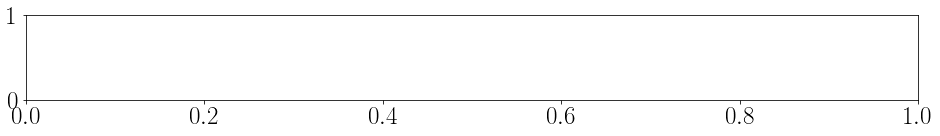

In [9]:
savedir = "cluster_results/iso_and_gyro"
gyro_only, iso_only = False, False
import corner

N = len(df)
for i in range(0, N):
    print(i, "of", N)
    
    iso_params = {"G": (obs.G[i], obs.G_err[i]),
                  "bp": (obs.bp[i], obs.bp_err[i]),
                  "rp": (obs.rp[i], obs.rp_err[i]),
                  "Kepler": (obs.Kepler[i], obs.Kepler_err[i]),
                  "parallax": (obs.parallax[i], obs.parallax_err[i])} 
    
    st = star(iso_params, prot[i], prot_err[i])
    sampler = st.fit(max_n=1000, savedir=savedir)

    truths = [None, np.log10(650e6), None, None, None]
    print("truths = ", truths)
    st.make_plots(truths, savedir, i)
    
#     nwalkers, nsteps, ndim = np.shape(sampler.chain)
#     assert burnin < nsteps, "The number of burn in samples to throw away" \
#         "can't exceed the total number of samples."
    
#     samples = sampler.flatchain
    
#     print("Plotting age posterior")
#     age_gyr = (10**samples[burnin:, 1])*1e-9
#     plt.hist(age_gyr)
#     plt.xlabel("Age [Gyr]")
#     med, std = np.median(age_gyr), np.std(age_gyr)
#     if truths[1]:
#         plt.axvline(10**(truths[1])*1e-9, color="tab:orange",
#                     label="$\mathrm{True~age~[Gyr]}$")
#     plt.axvline(med, color="k", label="$\mathrm{Median~age~[Gyr]}$")
#     plt.axvline(med - std, color="k", linestyle="--")
#     plt.axvline(med + std, color="k", linestyle="--")
#     plt.savefig("{0}/{1}_marginal_age".format(savedir, str(i).zfill(4)))
#     plt.close()

#     print("Plotting production chains...")
#     plt.figure(figsize=(16, 9))
#     for j in range(ndim):
#         plt.subplot(ndim, 1, j+1)
#         plt.plot(sampler.chain[:, burnin:, j].T, "k", alpha=.1)
#     plt.savefig("{0}/{1}_chains".format(savedir, str(i).zfill(4)))
#     plt.close()

#     print("Making corner plot...")
#     labels = ["$\mathrm{EEP}$",
#               "$\log_{10}(\mathrm{Age~[yr]})$",
#               "$\mathrm{[Fe/H]}$",
#               "$\ln(\mathrm{Distance~[Kpc])}$",
#               "$A_v$"]
#     corner.corner(samples[burnin:, :], labels=labels, truths=truths);
#     plt.savefig("{0}/{1}_corner".format(savedir, str(i).zfill(4)))
#     plt.close()
    
#     # Make mass histogram
#     samples = sampler.flatchain
#     mass_samps = mist.mass(samples[:, 0], samples[:, 1], samples[:, 2])
#     plt.hist(mass_samps, 50);
#     if truths[0]:
#         plt.axvline(truths[1], color="tab:orange", label="$\mathrm{True~mass~}[M_\odot]$")
#     plt.savefig("{0}/{1}_marginal_mass".format(savedir, str(i).zfill(4)))
#     plt.close()